# Трансформеры

##Последовательности: всё сразу

**Трансформер** — это семейство архитектур нейросетей, предложенное в 2017 году исследователями из **Google Brain** и основанное на механизме внимания.

В отличие от рекуррентных моделей трансформер обрабатывает входную **последовательность целиком** и позволяет каждому элементу напрямую учитывать любой другой элемент последовательности. Это обеспечивает хорошую масштабируемость и эффективную обработку длинных последовательностей.

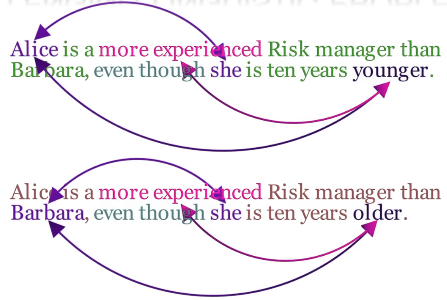

## Токенизация и подготовка текста

Перед подачей в нейросеть, которая всё так же способна обрабатывать лишь данные, представленные в виде наборов чисел, текст преобразуют в последовательность **токенов**.

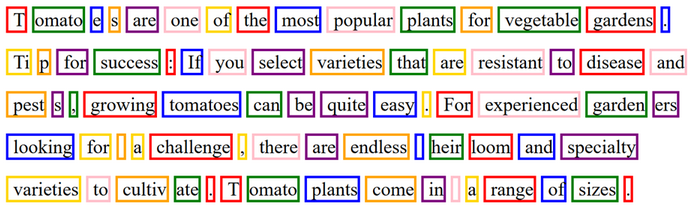

Токенизация состоит из строгой последовательности шагов. Сначала текст **нормализуют**. Например, переводят все слова в нижний регистр.

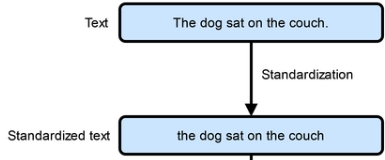

Затем текст **сегментируют** на субслова.

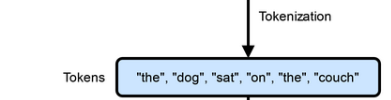

Далее каждому слову в соответствие ставится целочисленный $id$ из словаря, известного модели. То есть текст **индексируется**.

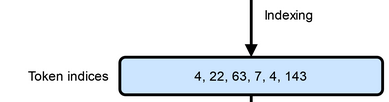

Затем от индексов переходят к представлению в виде набора чисел — **эмбеддинга**, каждый из этих наборов характеризует соответствующее слово. У похожих слов похожие эмбеддинги, у разных — разные.

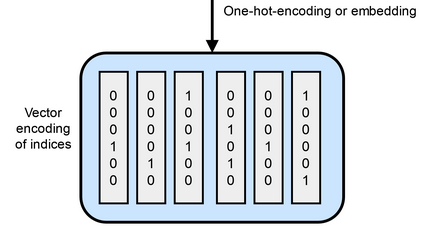

Полный процесс предобработки текста приведён ниже.

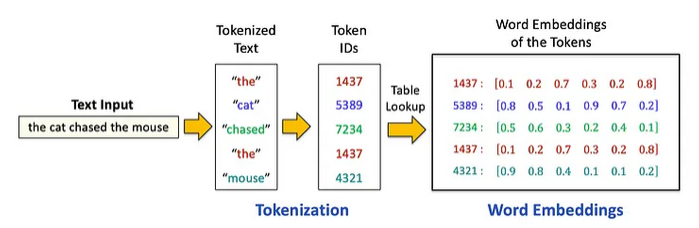

##Механизм внимания

Допустим, у нас есть предложение из $S$ слов. Разобьём его на элементы.

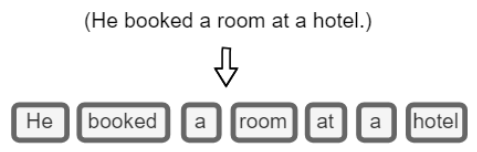

Каждый $i$-й элемент входной последовательности представим набором из $D$ чисел, которые называют **эмбеддингами**. Для этого элемента строятся три вектора: **запрос** $q_i$, **ключ** $k_i$ и **значение** $v_i$, такое представление называют `QKV`.

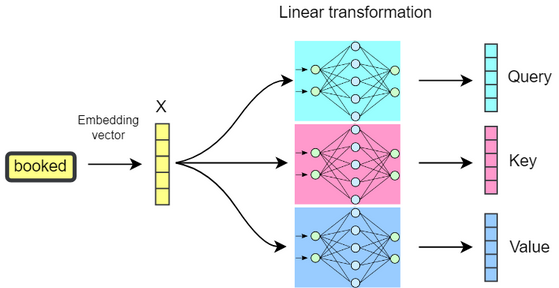

Чтобы понять, насколько информация с позиции $j$ **важна** для позиции $i$, сравниваем запрос $q_i$ с ключом $k_j$ поэлементно. Это можно сделать, как при вычислении схожести в рекомендательных системах, через **скалярное произведение**. Каждую компоненту $q_i$ умножаем на соответствующую компоненту $k_j$, а затем суммируем все результаты, чтобы получить единую скалярную оценку влияния позиции $j$ на позицию $i$:

$$
\text{score}_{ij} = \sum_{d=1}^{D} q_{i,d}  k_{j,d}
$$

Далее для каждой позиции $i$ скалярные оценки $\text{score}_{ij}$ для всех $j$ нормализуются в диапазон от $0$ до $1$ с помощью функции **softmax**. Полученные значения называют **коэффициентами внимания** $\alpha_{ij}$, которые показывают долю информации, поступающей с позиции $j$ к позиции $i$:

$$
\alpha_{ij} = \frac{\exp(\dfrac{\text{score}_{ij}}{\sqrt{D}})}{\displaystyle\sum_{l=1}^S \exp(\dfrac{\text{score}_{il}}{\sqrt{D}})}
$$

Разделение на $\sqrt{D}$ служит для **масштабирования** оценки, чтобы предотвратить слишком большие значения суммы по компонентам, которые могут привести к сильной насыщенности `softmax`.

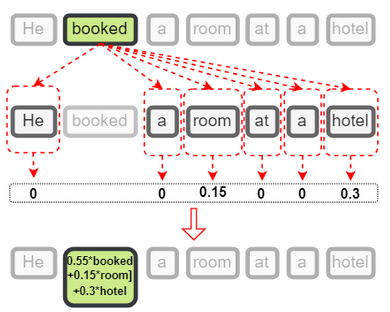

Наконец, для позиции $i$ формируется новое представление как **взвешенная сумма** всех значений $v_j$ с коэффициентами $\alpha_{ij}$:

$$
\text{out}_i = \sum_{j=0}^S \alpha_{ij}  v_j
$$


Таким образом, мы получили способ представлять слово через другие слова предложения. Полная схема процесса переведена ниже.

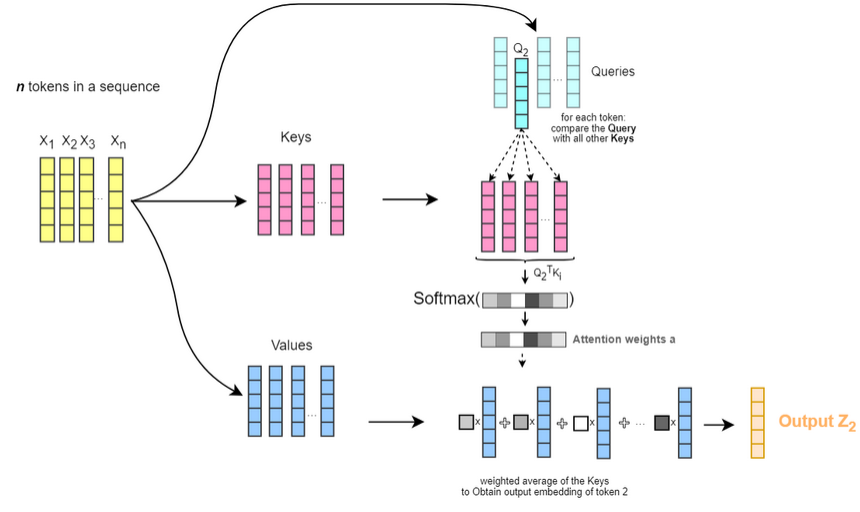

Более компактно приведённые операции можно представить как:

$$\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V$$



## Многоголовое внимание (Multi-Head Attention)

Описанное выше внимание называют $Self\ Dot-Product\ Attention$.Чтобы уловить разные типы зависимостей, внимание выполняют параллельно для нескольких наборов весов, называемых **головами**. Для головы $h$ формируются собственные поэлементные вектора $q^{(h)}$, $k^{(h)}$, $v^{(h)}$. Для каждой головы используют приведённые выше формулы.

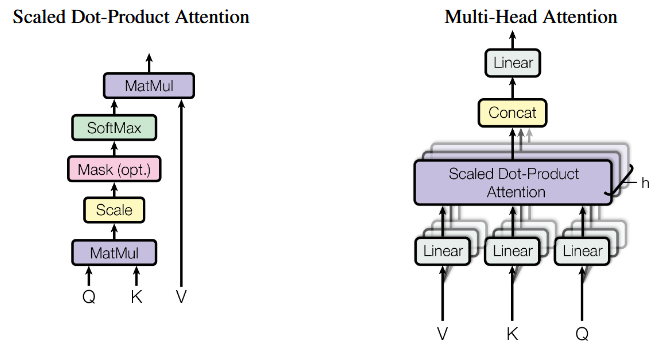

Затем **выходы** всех голов поэлементно объединяют конкатенацией компонент по каналу представления либо суммой соответствующих компонент векторов. Полученное поэлементное представление передаётся далее в слой преобразования для согласования размерностей.

## Трансформеры

**Трансформер** — это нейросеть, структурно содержащая приведённые выше блоки самовнимания. Нейросети-трансформеры делятся на два типа: **энкодеры** и **декодеры**.

Энкодер кодирует переданную в него последовательность в набор чисел, а декодер разворачивает числа в последовательность. С таким подходом мы познакомились в рамках лекции по генеративному искусственному интеллекту. Ниже схема трансформера, содержащего обе части, из оригинальной статьи **`Google`**.

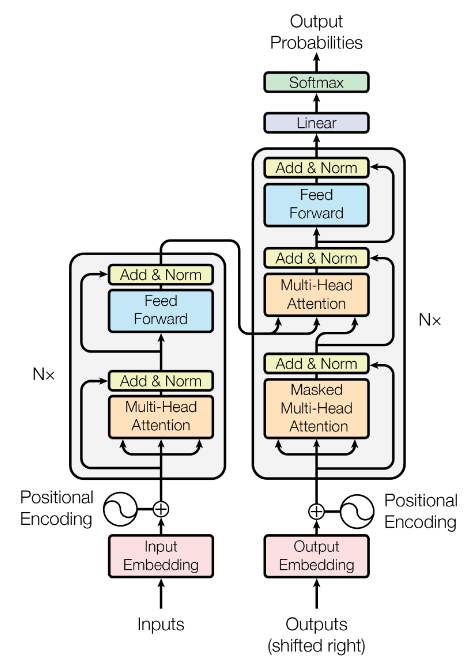

##Энкодер и декодер

Для начала рассмотрим только энкодер. Каждый из $N$ **блоков** энкодера состоит из **двух** последовательных шагов.

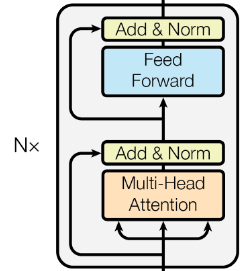

На первом шаге выполняется **многоголовое `self-attention`**. Для каждой позиции входной последовательности вычисляется новое поэлементное представление, в котором каждая компонента учитывает информацию со всех позиций последовательности. Размерность представления при этом сохраняется.

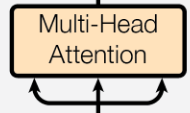

После `self-attention` применяется **остаточная связь**: для каждой позиции и каждой компоненты результат `attention` поэлементно складывается с исходным входом. Такая операция позволяет сохранить исходное представление позиции и облегчает обучение глубокой сети.

Затем выполняется **нормализация слоя**, которая по компонентам приводит значения каждой позиции к сопоставимому масштабу. Нормализация выполняется отдельно для каждой позиции и не смешивает информацию между разными токенами.

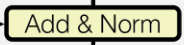

На втором шаге применяется позиционно независимая **двуслойная** нелинейная сеть `MLP` $(feed-forward)$.

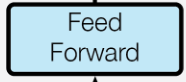

Эта сеть обрабатывает каждую позицию **независимо от остальных**, используя одни и те же параметры для всех позиций.

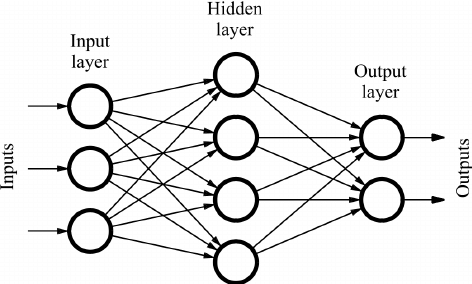

После `feed-forward` слоя снова применяется **остаточная связь**: его выход поэлементно прибавляется к входу этого шага. Затем выполняется **слой-нормализация**, стабилизирующая значения компонент для каждой позиции.


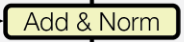

В итоге каждый блок энкодера чередует **два типа преобразований**:
`self-attention`, который смешивает информацию между позициями, и `feed-forward` сеть, которая поэлементно преобразует представление каждой позиции отдельно, используя остаточные связи и нормализацию для устойчивого обучения.

Заметим, что типовой блок **декодера** устроен из тех же элементов, что и блок энкодера.

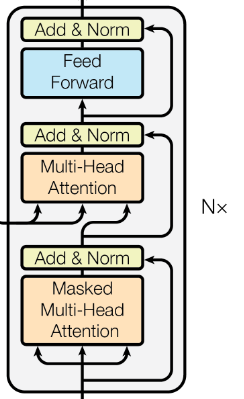

## Позиционные кодировки

Из описания выше нетрудно заметить, что трансформер не учитывает **порядок** элементов в последовательности. То есть их перемешивание не меняет результата.

Поэтому к эмбеддингам добавляют позиционные **кодировки**. Они состоят в том, что каждой позиции ставится в соответствие свой эмбеддинг из $D$ чисел, однозначно эту позицию кодирующий. Часто используют синусно-косинусные кодировки по компонентам.

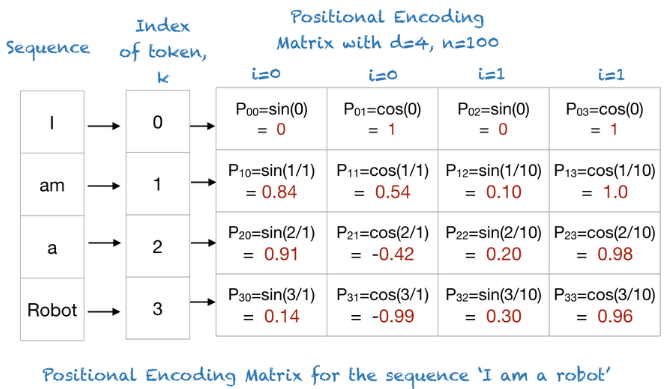

## Архитектурные варианты трансформеров

###Декодерный трансформер (GPT)

Использует только **декодерную** часть. На обучении предсказывает следующий токен по всем предыдущим, то есть учится последовательно генерировать текст. На похожей идее основана старая система автопродолжения текста `T9`. Первая модель `GPT` (`Generative Pre-trained Transformer `) была предложена компанией `OpenAI` 11 июня 2018 года.

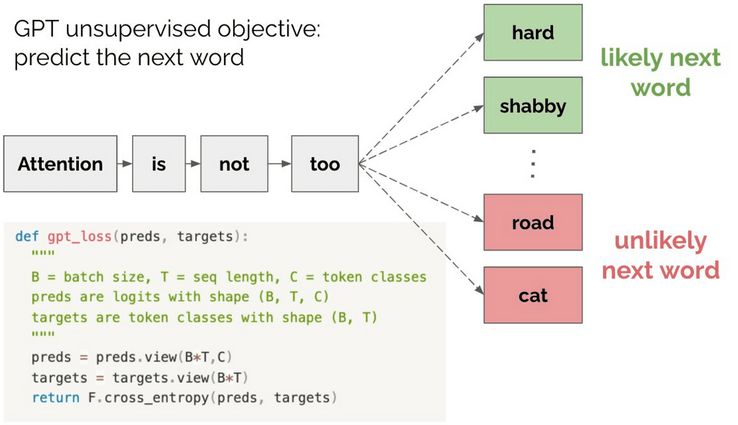

В практике для обучения применяется метод `teacher forcing`: на каждом шаге модель получает корректный префикс и минимизирует ошибку предсказания следующего токена. Такие модели особенно хороши для задач генерации и **диалогов**. Модель может генерировать сразу несколько цепочек из следующих слов, будут выбраны `top@k` лучших. Это называется `beam search`.

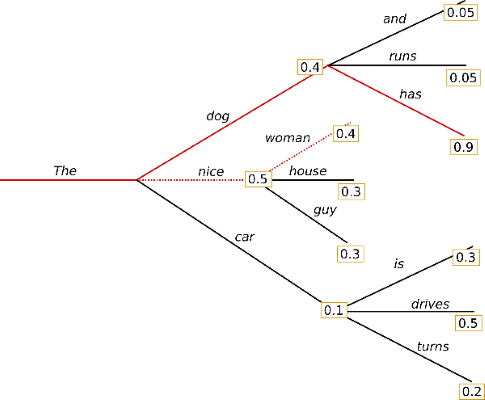

###Энкодерные модели (BERT)

Используют только **энкодер** и обучаются на задачах понимания контекста. Первая модель `BERT` (`Bidirectional Encoder Representations from Transformers`) была предложена `Google` в 2019 году для обработки англоязычного текста.

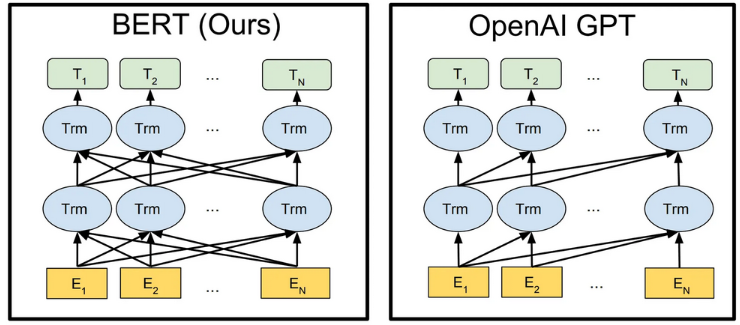

Основной приём в обучении — `Masked Language Modeling`: некоторые токены замаскированы, модель должна восстановить их по окружению. Благодаря этому модель учится одновременно использовать левый и правый контекст, что делает её удобной для классификации, извлечения сущностей и поиска ответов в тексте.

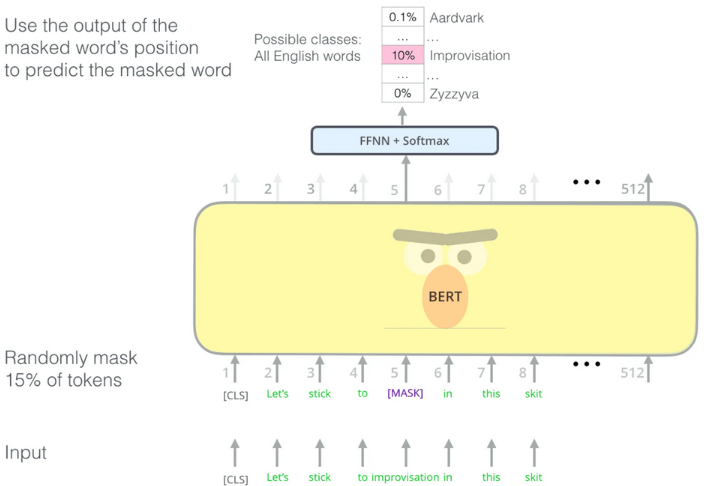

###Энкодер-декодер

**Энкодер** принимает входную последовательность и кодирует каждую позицию в вектор одинаковой размерности. **Декодер** получает эти векторы и генерирует выходную последовательность, на каждом шаге сочетая собственное (маскированное) самовнимание с вниманием к представлениям энкодера.

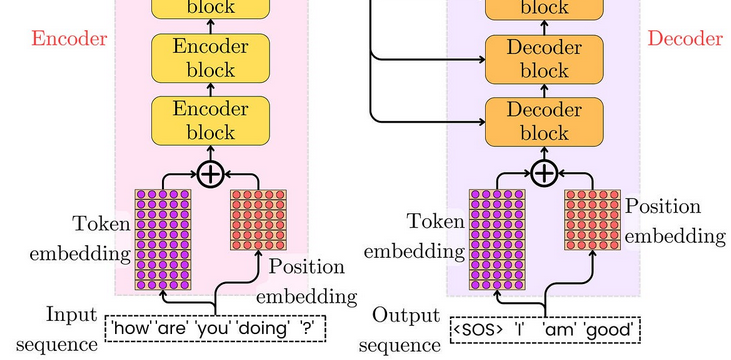

Обучение проводится как задача преобразования **строки в строку**: модель сопоставляет вход и желаемый выход и учится восстанавливать целевой текст по заданному входу. Ниже приведён пример **перевода** текста с английского на немецкий. Энкодер кодирует английский текст в набор чисел. Декодер видит это представление, сначала генерирует первое слово перевода, затем второе, третье и так далее до конца последовательности `end of sequence` (`EOS`). Трансформеры с такой архитектурой также хорошо подходят для задачи суммаризации текста.

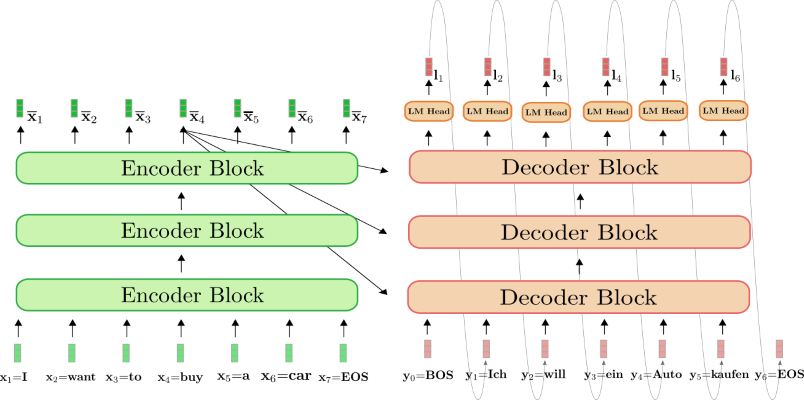

Модель `T5` (`Text-To-Text Transfer Transformer`) была представлена `Google` в 2020 году как универсальный метод обработки текста, который переводит все задачи `NLP` в формат преобразования текста в текст.

Модель `BART` (`Bidirectional and Auto-Regressive Transformers`) была представлена в 2019 году, сочетая элементы как автокодировщиков, так и авторегрессионных моделей для улучшения генерации текста и понимания.

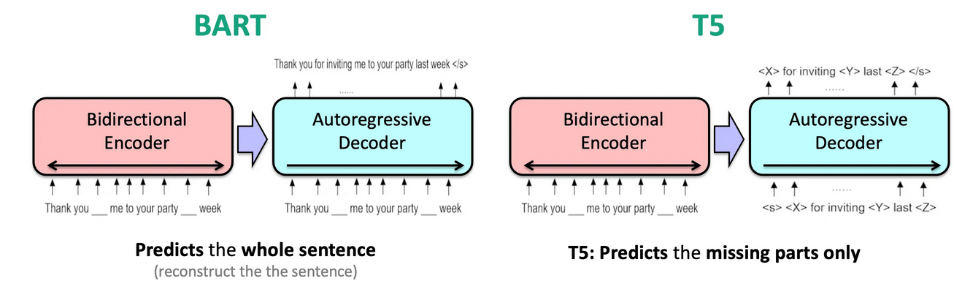

##Бенчмарки трансформеров

###Perplexity
Используется для оценки языковых моделей, обученных на задаче предсказания следующего токена, прежде всего декодерных моделей типа `GPT`. Показывает, насколько уверенно модель предсказывает текст: чем ниже `perplexity`, тем лучше модель аппроксимирует распределение языка. Метрика чувствительна к домену данных и плохо отражает качество смысловой генерации.


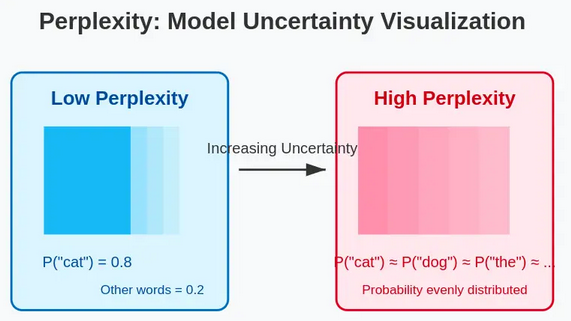

###BLEU
Применяется в задачах машинного перевода. Оценивает совпадение `n`-грамм между сгенерированным текстом и эталонным переводом с учётом штрафа за слишком короткие ответы. Хорошо работает для перевода, но плохо коррелирует с качеством в задачах свободной генерации.

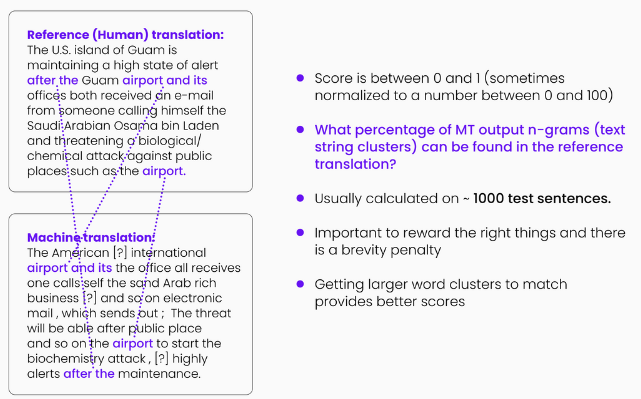

###ROUGE
Используется в задачах суммаризации. Измеряет перекрытие слов и фрагментов между сгенерированным текстом и референсным резюме. Предпочтительна для оценки кратких пересказов, но не учитывает перефразирование и смысловые замены.


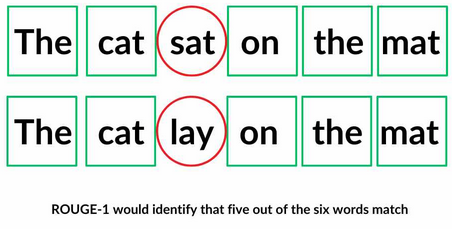

###GLUE
Набор бенчмарков для оценки энкодерных моделей типа `BERT` на задачах понимания текста. Включает классификацию, распознавание логических отношений и анализ сходства предложений. Позволяет сравнивать модели по единому агрегированному скору.

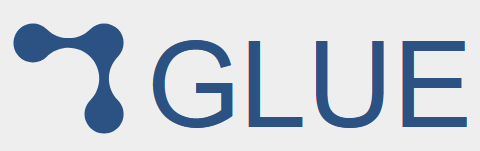


###SuperGLUE
Усложнённая версия GLUE, ориентированная на более глубокое понимание языка. Содержит задачи, требующие рассуждений, работы с контекстом и кореференцией. Современные большие модели достигают или превосходят человеческий уровень на этом наборе.


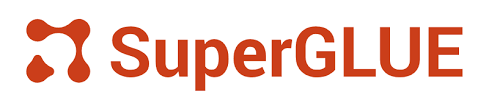

###SQuAD
Бенчмарк для извлечения ответов на вопросы из текста. Модель должна найти точный фрагмент в контексте, отвечающий на заданный вопрос. Часто используется для оценки энкодерных и энкодер-декодерных моделей в `QA`-задачах.


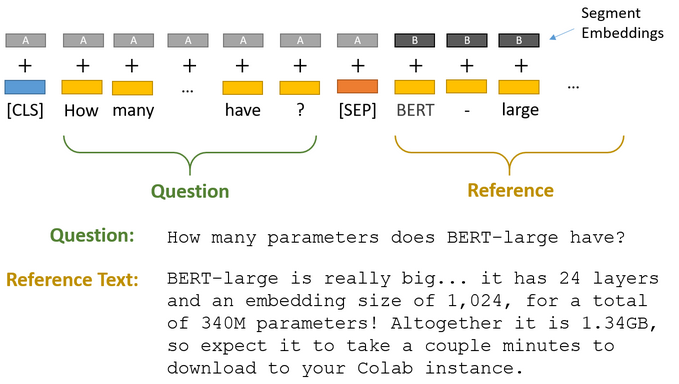

##Трансформеры не для текстов

###Vit

Трансформеры хорошо справляются с любыми задачами, где есть последовательные данные. В частности задачу обработки изображений решает **`Vision Transformer`** (`ViT`). Всё изображение разбивается на небольшие квадраты ($patch$), каждый квадрат воспринимается моделью как токен.

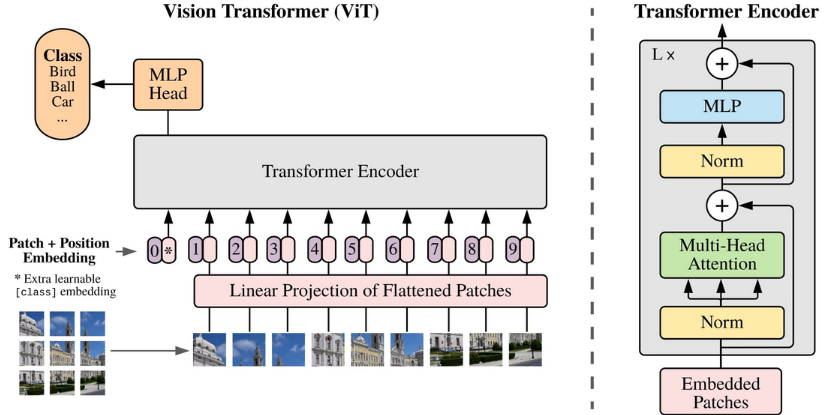

###Whisper AI

Трансформеры применимы к обработке **аудио**. Всякий сложный звук можно представить в виде суммы отдельных звуков разных частот, обычно от 32 до 256. Аудио в каждый момент времени представимо в виде набора громкостей компонент с разными частотами. Для каждого момента времени получим эти значения громкостей. Тогда сформируется `2D` изображение, где по вертикали откладываются громкости, а по горизонтали время. Такое представление называют **спектрограммой**.

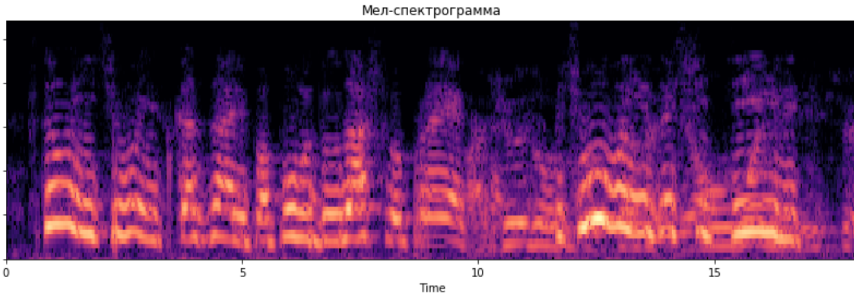

Токеном для трансформера послужит набор громкостей. Последовательность — набор этих токенов. На такой архитектуре базируется трансформер **`Whisper AI`** от компании `OpenAI`, предложенный в 2022 году.

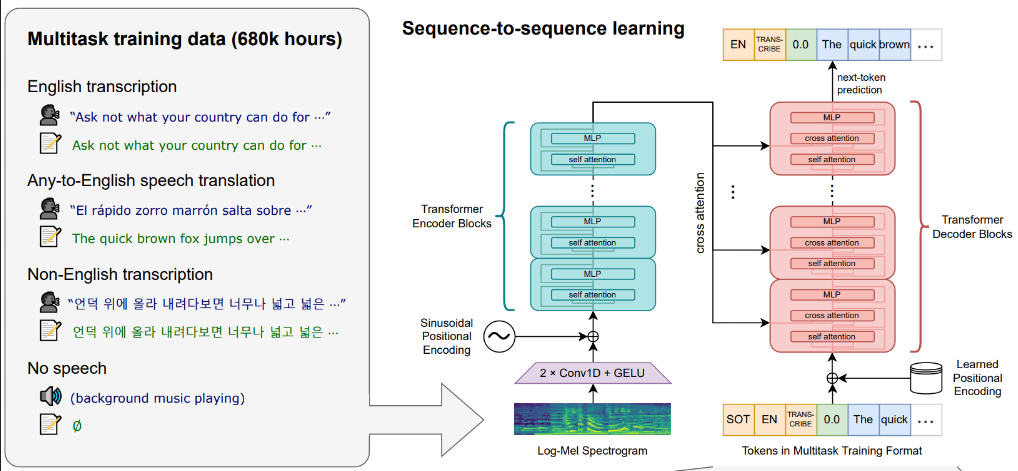

##Примеры. Решение задач NLP

###Transformers

Для разработки и обучения языковых моделей принято использовать библиотеку **`Transformers`**, разработанную компанией `Hugging Face`. На сайте компании, как и на `Kaggle`, можно размещать свои или загружать чужие датасеты. Также реализован функционал для выгрузки обученных весов моделей на сайт, модуль совместим с `torch`, что делает платформу универсальной.

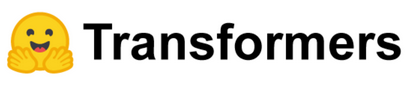

Установим `transformers`.

In [2]:
!pip install -q transformers sentencepiece

Импортируем `torch`. Современные модели весят от гигабайтов до сотен гигабайт и требуют запуска на производительных `GPU`.

In [3]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Импортируем автоматический токенизатор `AutoTokenizer` и модели `AutoModel`.

In [4]:
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    AutoModelForTokenClassification,
    AutoModelForQuestionAnswering,
    AutoModelForSeq2SeqLM,
    AutoModelForCausalLM
)

###Токенизация текста

Токенизируем текст на русском. Используем модель `BERT`, обученную на русскоязычных текстах, — `RuBERT`. Она автоматически скачается с `Hugging Face`. Необходимую модель можно найти либо через поиск на сайте, либо через привычные поисковые системы.

В названии модели `cased` значит, что она учитывает регистр, что важно при работе с именами собственными. `base` означает, что это базовая версия модели, параллельно могут быть `large` и `small`.

In [5]:
tokenizer = AutoTokenizer.from_pretrained("DeepPavlov/rubert-base-cased")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Получили разбиения текста на субслова и пунктуацию, которые затем преобразовались в `id`.

In [7]:
text = "МИФИ — один из лучших инженерно-физических вузов в мире."
tokens = tokenizer.tokenize(text)
ids = tokenizer(text, return_tensors="pt")
print(tokens)
print(ids["input_ids"])

['МИФИ', '—', 'один', 'из', 'лучших', 'инженерно', '-', 'физических', 'вузов', 'в', 'мире', '.']
tensor([[  101, 89885,   901,  5259,  1703, 14337, 35714,   130, 27152, 30406,
           845, 10826,   132,   102]])


###Sentiment analysis

Решим задачу определения тональности текста. Положительные тексты получают результат, близкий к $1$, негативные — к $0$.

In [11]:
endpoint = 'blanchefort/rubert-base-cased-sentiment'
tokenizer = AutoTokenizer.from_pretrained(endpoint)
model = AutoModelForSequenceClassification.from_pretrained(endpoint).to(device)

model.safetensors:   0%|          | 0.00/711M [00:00<?, ?B/s]

Модель вернёт результат в виде вероятностей трёх классов: `NEUTRAL`, `POSITIVE`, `NEGATIVE`. Модель предсказывает, что текст положительный.

In [14]:
text = "Отличный получился курс. Теперь ИИ для меня не чёрный ящик, ура!"
inp = tokenizer(text, return_tensors="pt", truncation=True, padding=True).to(device)
out = model(**inp)
logits = out.logits.detach().cpu()
probs = torch.softmax(logits, dim=-1).numpy().squeeze()
print(probs)

[0.01723151 0.97861326 0.00415529]


###Zero-shot классификация

Так как моделям понятно значение слов, модели не обязательно дообучать в задачах классификации. В качестве метки можно использовать сами слова. Такой подход называют **`zero-shot`**.

Применение предобученных моделей называют **инференсом**, а конкретно в нашей задаче это `Multi-Genre Natural Language Inference`.

In [20]:
endpoint = 'DeepPavlov/xlm-roberta-large-en-ru-mnli'
tokenizer = AutoTokenizer.from_pretrained(endpoint)
model = AutoModelForSequenceClassification.from_pretrained(endpoint).to(device)

tokenizer_config.json:   0%|          | 0.00/587 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/944k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/238 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/954 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.36G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.36G [00:00<?, ?B/s]

Возьмём отзыв о фильме и выдвинем три гипотезы о его тональности. `BART` выявит наболее подходящую на основе сравнения с самим текстом.

In [21]:
sequence = "Этот фильм был слишком тёмным и скучным."
candidate_labels = ["позитивный отзыв", "негативный отзыв", "нейтральный отзыв"]
hypotheses = [f"Это текст с темой: {lab}." for lab in candidate_labels]
inputs = tokenizer(
    [sequence] * len(hypotheses),
    hypotheses,
    return_tensors="pt",
    padding=True,
    truncation=True
).to(device)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Выведем результаты. Модель вернёт ответ в формате `[entailment, neutral, contradiction]`. Видим, что гипотеза об отрицательности отзыва воспринимается как следствие из отзыва, вероятность $0.997$.

In [22]:
outputs = model(**inputs)
logits = outputs.logits.detach().cpu()
scores = torch.softmax(logits, dim=-1).numpy()
print(scores)

[[9.9663109e-01 3.2271249e-03 1.4177780e-04]
 [3.9865963e-02 9.5433038e-01 5.8035702e-03]
 [2.5114414e-01 7.3391819e-01 1.4937648e-02]]


###Перевод

Переведём эту фразу с русского на английский.

In [23]:
tokenizer = AutoTokenizer.from_pretrained("Helsinki-NLP/opus-mt-ru-en")
model = AutoModelForSeq2SeqLM.from_pretrained("Helsinki-NLP/opus-mt-ru-en").to(device)

tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

source.spm:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/803k [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


pytorch_model.bin:   0%|          | 0.00/307M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/307M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

Выведем результат.

In [25]:
text = "Переведём эту фразу с русского на английский."
inp = tokenizer(text, return_tensors="pt").to(device)
out = model.generate(**inp, max_length=40)
print(tokenizer.decode(out[0], skip_special_tokens=True))

Let's translate this phrase from Russian to English.


###Пересказ

Решим задачу суммаризации текста на примере первого абзаца этой лекции. Используем `T5`, дообученную в Сбере на русскоязычных текстах.

In [44]:
from transformers import GPT2Tokenizer, T5ForConditionalGeneration

tokenizer = GPT2Tokenizer.from_pretrained('RussianNLP/FRED-T5-Summarizer',eos_token='</s>')
model = T5ForConditionalGeneration.from_pretrained('RussianNLP/FRED-T5-Summarizer').to(device)

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

added_tokens.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/688 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/853 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/1.97G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/133 [00:00<?, ?B/s]

Первый абзац данной лекции. Добавим префикс-токен `<LM>`, необходимый для работы конкретно данной модели.

In [45]:
input_text = """
<LM>Трансформер — это семейство архитектур нейросетей, предложенное в 2017
 году исследователями из Google Brain и основанное на механизме внимания.

В отличие от рекуррентных моделей трансформер обрабатывает входную
последовательность целиком и позволяет каждому элементу напрямую
учитывать любой другой элемент последовательности. Это обеспечивает хорошую
масштабируемость и эффективную обработку длинных последовательностей.
"""

Сделаем предикт в соответствии с примером со страницы модели на `Hugging Face`.

In [47]:
input_ids=torch.tensor([tokenizer.encode(input_text)]).to(device)
outputs=model.generate(
    input_ids,
    eos_token_id=tokenizer.eos_token_id,
    num_beams=5,
    min_new_tokens=17,
    max_new_tokens=200,
    do_sample=True,
    no_repeat_ngram_size=4,
    top_p=0.9
)

Выведем результат.

In [48]:
print(tokenizer.decode(outputs[0][1:]))

Исследователи из Google Brain разработали семейство архитектур нейросетей 
трансформеров, которые обрабатывают входную последовательность целиком и 
позволяют каждому элементу напрямую учитывать любой другой элемент 
последовательности. Это обеспечивает хорошую масштабируемость и эффективную 
обработку длинных последовательностей.</s>


##Выводы

В ходе занятия мы:

1. Познакомились с трансформерами.
2. Изучили этапы обработки текста перед попаданием в языковую модель.
3. Проанализировали механизм внимания.
4. Изучили архитектурные блоки трансформеров.
5. Рассмотрели различные комбинации энкодеров и декодеров, ознакомились с современными реализациями.
6. Привели традиционные бенчмарки для языковых моделей.
7. Описали трансформеры для работы с изображениями и аудио.
8. Решили основные задачи обработки текста с использованием предобученных моделей `Hugging Face`.

##Данные об авторе

Зюков Алексей Алексеевич,

лаборант отдела-онлайн образования НИЯУ МИФИ,

бакалавр кафедры суперкомпьютерных технологий в инженерно-физическом моделировании НИЯУ МИФИ.

##Список использованной и рекомендованной литературы

1. Егоров, А. Д. Репозитории с лекциями по анализу данных в НИЯУ МИФИ. – Текст : электронный. / А. Д. Егоров // GitHub : [сайт]. – URL: https://github.com/ShadarRim (дата обращения: 01.11.2025).
2. Малов, Д. А. Глубокое обучение и анализ данных : практическое руководство. / Д. А. Малов. – Текст : непосредственный. – Санкт-Петербург : БХВ-Петербург, 2023. – 272 с. : ил. – ISBN 978-5-9775-1172-8.
3. Рябинин, М. Трансформеры. – Текст : электронный. / Максим Рябинин ; Яндекс.Образование. – URL: https://education.yandex.ru/handbook/ml/article/transformery (дата обращения: 01.11.2025).
4. Attention Is All You Need / A. Vaswani, N. Shazeer, N. Parmar [и др.]. — Текст : электронный // arXiv.org : [сайт]. — 2017. — 12 июня. — URL: https://arxiv.org/pdf/1706.03762 (дата обращения: 01.11.2025).
5. Pichka, E. What is Query, Key, and Value (QKV) in the Transformer Architecture and Why Are They Used? / E. Pichka. — Текст : электронный // Ebrahim Pichka : [сайт]. — 2023. — 4 окт. — URL: https://epichka.com/blog/2023/qkv-transformer/ (дата обращения: 01.11.2025).
6. The Hugging Face Course, 2022. — Текст : электронный // Hugging Face : [образовательная платформа]. — 2022. — URL: https://huggingface.co/learn/llm-course (дата обращения: 01.11.2025).